# Attitude determination

## october campaign

### load data from logs

In [1]:
date='2021-18-17'
import os
import pandas as pd
#aug1=pd.read_csv(indir+date+'/hk_data_decoded.txt',delimiter='\t')
oct1=pd.read_csv("/home/limu/Space/logs/alpha/hk_data_october_17.txt",delimiter='\t')
oct1.columns

Index(['RealTimeStamp', 'DK EpochTimeStamp [s]', 'DK TimeStamp', 'CunkID',
       'ChunkType', 'Length [B]', 'LdSt magX [nT]', 'LdSt magY [nT]',
       'LdSt magZ [nT]', 'LdStTot [nT]', 'OBC magX [nT]', 'OBC magY [nT]',
       'OBC magZ [nT]', 'OBCtot [nT]', 'OBC_9DOF_Temp [*C]',
       'OBCgyroX [deg/s]', 'OBCgyroY [deg/s]', 'OBCgyroZ [deg/s]',
       'OBCaccX [mG]', 'OBCaccY [mG]', 'OBCaccZ [mG]', 'SolT X+ [*C]',
       'SolT Y+ [*C]', 'SolT X- [*C]', 'SolT Y- [*C]', 'SolT Z- [*C]',
       'OBC_Temp [*C]', 'ssTemp(X+) [*C]', 'ssTemp(Y+) [*C]',
       'ssTemp(X-) [*C]', 'ssTemp(Y-) [*C]', 'ssTemp(Z-) [*C]', 'ssIRRad(X+)',
       'ssIRRad(Y+)', 'ssIRRad(X-)', 'ssIRRad(Y-)', 'ssIRRad(Z-)',
       'ssAngleX (X+) [deg]', 'ssAngleY (X+) [deg]', 'ssAngleX (Y+) [deg]',
       'ssAngleY (Y+) [deg]', 'ssAngleX (X-) [deg]', 'ssAngleY (X-) [deg]',
       'ssAngleX (Y-) [deg]', 'ssAngleY (Y-) [deg]', 'ssAngleX (Z-) [deg]',
       'ssAngleY (Z-) [deg]', 'ssGyroX (X+) [deg/s]', 'ssGyroY (X+) [deg/s

In [208]:
mok=oct1
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
from datetime import datetime,timedelta
mags=np.array([np.array(mok[mok.columns[6+i]]) for i in range(3)]).T
mags=mags[1:-1]
times=[datetime.strptime(m,"%d-%m-%Y %H:%M:%S") for m in mok['DK TimeStamp']]
dt=np.array([(t-times[0]).seconds for t in times])


[[<matplotlib.lines.Line2D at 0x7fe475c5b430>],

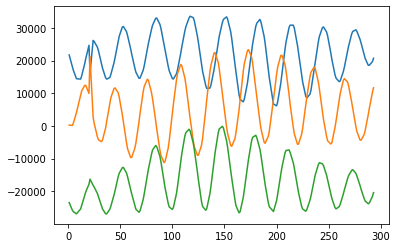

In [209]:
[pl.plot(dt[1:-1],m) for m in mags.T]

#### angles and gyros

set of five 2axis datas from gyro sensors on Lode modules (really? Lode has 3-axis gyro)

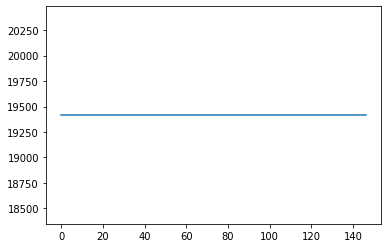

In [80]:
pl.plot(mok['OBC magX [nT]'])
#OBC magnetometr nefunguje!

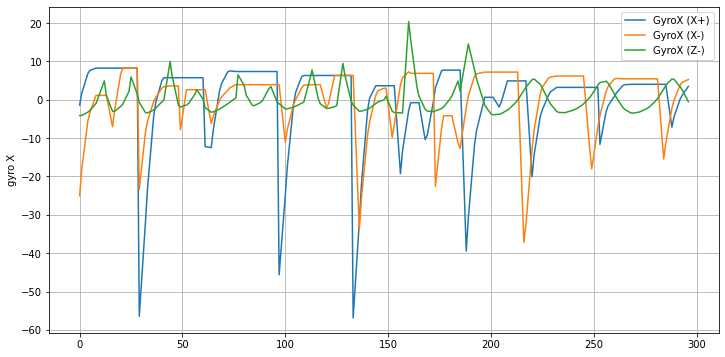

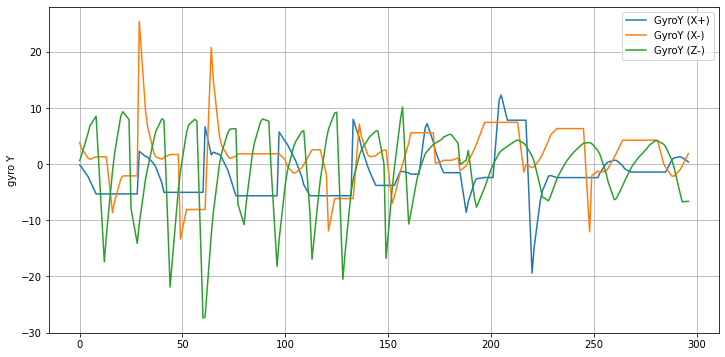

In [3]:
pl.figure(figsize=(12,6))
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-10::4]]#[-9::2]
pl.ylabel("gyro X")
pl.legend()
pl.grid()
pl.figure(figsize=(12,6))
pl.ylabel("gyro Y")
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-9::4]]
pl.legend()
pl.grid()

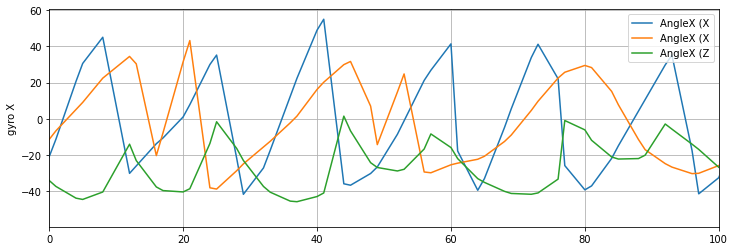

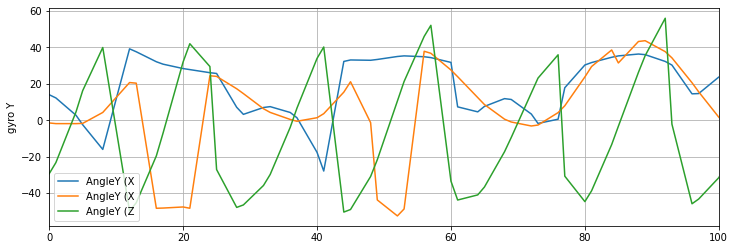

In [4]:
tmax=100
pl.figure(figsize=(12,4))
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-10-10:-10:4]]#[-9::2]
pl.ylabel("gyro X")
pl.legend()
pl.xlim(0,tmax)
pl.grid()
pl.figure(figsize=(12,4))
pl.ylabel("gyro Y")
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-9-10:-10:4]]
pl.legend()
pl.xlim(0,tmax)
pl.grid()

In [5]:
## no 
geero=[i for i,m in enumerate(mok.columns) if m.find('OBCgyro')>=0]
[mok[mok.columns[i+3]].std() for i in geero] #no data here
#pl.plot(dt,mok[mok.columns[geero[2]]]) 

[0.0, 0.0, 0.0]

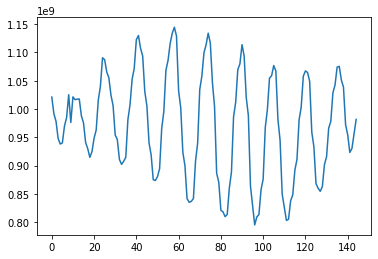

In [6]:
pl.plot((mags**2).sum(1))

Text(0.5, 1.0, 'Solar panel temps')

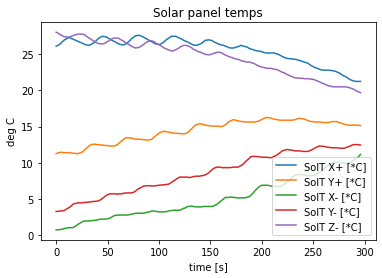

In [7]:
tpanel=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in range(21,26)]])
[pl.plot(dt,t) for t in tpanel]
pl.legend([mok.columns[i] for i in range(21,26)])
pl.ylabel("deg C")
pl.xlabel("time [s]")
pl.title("Solar panel temps")

Text(0.5, 1.0, 'SunSensor temps')

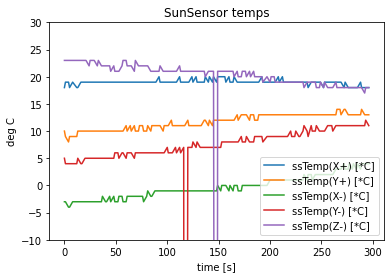

In [8]:
tpanel=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in range(27,32)]])
[pl.plot(dt,t) for t in tpanel]
pl.legend([mok.columns[i] for i in range(27,32)])
pl.ylim(-10,30)
pl.ylabel("deg C")
pl.xlabel("time [s]")
pl.title("SunSensor temps")

In [129]:
irpos=[i for i in range(len(mok.columns)) if mok.columns[i].find("IRR")>0]
rep=[]
qth = (48.7408,-21.2284,380)
from astropy import coordinates as coord
from astropy import units as u
import predict

tle= """GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965"""
#tle= """GRBALPHA
#1 47959U 21022AD  22089.06574127  .00004075  00000-0  27671-3 0  9996
#2 47959  97.5376 350.3030 0022746  59.5456 300.8062 15.06733026 54867"""

pars=['longitude','latitude','altitude','epoch']
kosice=coord.EarthLocation.from_geodetic(qth[1],-qth[0],qth[2])#,unit=(u.degree, u.degree,u.meter))
kosrad=np.sqrt(sum(np.array(kosice.value.tolist())**2))*1e-3 #earth distance in km

d=mok['DK TimeStamp'][0]
x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
y=predict.observe(tle, qth, at=x.timestamp())
print([y['longitude'],y['latitude'],y['altitude']])

tle= """GRBALPHA
1 47959U 21022AD  21261.56473559  .00000999  00000-0  72704-4 0  9998
2 47959  97.5478 161.8339 0022206 358.3728 121.5047 15.05855836 25884"""

for d in mok['DK TimeStamp']:
    x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
    y=predict.observe(tle, qth, at=x.timestamp())
    rep.append([y['longitude'],y['latitude'],y['altitude']])
print(rep[0])
rep=np.array(rep).T
if rep[0].max()-rep[0].min()>200:rep[0]=(rep[0]+180)%360-180

[294.62560622779716, -62.09383739345331, 557.2180755783047]
[262.5607850157825, -79.68199158282104, 561.3757175949504]


In [127]:
datetime.now().timestamp()/3600/24

19122.618451049744

#### magnetic field

World Magnetic Model from http://geomag.bgs.ac.uk/data_service/models_compass/wmm_calc.html

In [130]:
from periodogram import get_mag_dir

pomag=[]
for i in [0,len(rep)-1]:
    day=mok['DK TimeStamp'][i].split(' ')[0]
    day='-'.join(day.split('-')[::-1])
    pomag.append(get_mag_dir(day,rep[1][i],rep[0][i],rep[2][i]))
    
pom1,pom2=pomag[0],pomag[-1]
vecs=[np.array([dic[t+'-intensity'] for t in ['east','north','vertical']]) for dic in pomag]#'declination'] 
norm=lambda v:np.sqrt(np.dot(v,v))
nvecs=[v/norm(v) for v in vecs]
nvecs

[array([ 0.24458514,  0.22145782, -0.94399923]),
 array([ 0.24654192,  0.21527611, -0.94491972])]

In [131]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in rep.T] 
import periodogram as pg
sunvec_hall=np.array([pg.sun_vec_CHall(t) for t in times])

In [132]:
all_rot=[]
from satutils import triad
dtot=dt[-1]
magdir=[coord.SkyCoord(pomag[i]['inclination'],pomag[i]['declination'],unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]
magvec=[np.array([c.x.value,c.y.value,c.z.value]) for c in [m.fk5.cartesian for m in magdir]]
magvec=[m/norm(m) for m in magvec]
mag_inter = lambda t:(t/dtot*magvec[1]+(1-t/dtot)*magvec[0])



In [133]:
## prediction of Sun direction in body frame?

print(np.array([sunvec_hall[i] for i in [1,10,-1]])) # in ECI
#from astropy.coordinates import get_body_barycentric, get_body, get_sun, EarthLocation
from astropy.time import Time
sunvec_apy=[]  #coord.get_sun(Time(t)) for j,t in enumerate(times)]
#for j,s in enumerate(sunvec_apy):
for j in range(len(times)):
    loc=coord.EarthLocation.from_geodetic(rep[0][j],rep[1][j],rep[2][j]*1e3)
    sunvec_apy.append(coord.get_sun(time=Time(times[j])))
    sunvec_apy[-1].location=loc
    #print(rep[0][j],rep[1][j])
import satutils as su
sunvec_loc=[su.fromangle(s.altaz.az.value,s.altaz.alt.value) for s in sunvec_apy] #local frame
sunvec_eci=[su.fromangle(s.ra.value,s.dec.value) for s in sunvec_apy] #equatorial
np.array([sunvec_eci[i] for i in [1,10,-1]])

[[-0.79041381 -0.56203706 -0.2436398 ]
 [-0.79041138 -0.56203993 -0.24364105]
 [-0.79037797 -0.56207949 -0.2436582 ]]


array([[-0.91553827, -0.36904756, -0.15997989],
       [-0.91553666, -0.36905093, -0.15998135],
       [-0.9155145 , -0.36909721, -0.16000141]])

In [134]:
j=0
coo=coord.AltAz(0*u.deg,-90*u.deg,obstime=times[j], location=satcoor2[j])
coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
sco=coord.SkyCoord(coo)#,frame='altaz')
nadir=sco
sco.icrs, rep[:,j],tm.deg,sco.separation(sunvec_apy[j]).deg

(<SkyCoord (ICRS): (ra, dec) in deg
     (173.13377064, 79.80301342)>,
 array([262.56078502, -79.68199158, 561.37571759]),
 353.4716814100295,
 90.24622821071249)

In [135]:
sco.separation(sunvec_apy[j]).deg

90.24622821071249

In [136]:
coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
tm.deg

353.4716814100295

### finding proper sun direction

- fix the magnetic field direction
- est. angle between sun and magnet
- vary "azimuth" of sun vector to fit best the observation

In [137]:
angle=[np.arccos(np.dot(mag_inter(dt[i]),sunvec_hall[i])) for i in range(len(dt))]
#pl.plot(np.rad2deg(angle))
angle2=np.array([np.arccos(np.dot(mag_inter(dt[i]),sunvec_eci[i])) for i in range(len(dt))])
angle=np.mean(angle) #changes negligeable
print(np.rad2deg(np.max(angle2)-np.min(angle2)))
print(np.rad2deg((np.max(angle2)+np.min(angle2))/2))
#angle2=np.mean(angle2)
#np.rad2deg(angle),np.rad2deg(angle2)

49.44574065365949
59.00516838598996


In [139]:
np.rad2deg(angle2[-1])

34.28229805916021

angle2 - between Sun and magnet. North
wee - vector (set of..) with angle2 from `[1,0,0]` 

    rmatx@mbody -> [1,0,0]
    rmatx.T@[1,0,0] -> mbody
    
    rmatx.T@wee -> body frame

In [215]:
mbody=np.array([m/norm(m) for m in mags])
phi=np.r_[:2*np.pi:40j]
j,k=3,20
wee=np.array([np.cos(angle2[j]),np.sin(angle2[j])*np.cos(phi[k]),np.sin(angle2[j])*np.sin(phi[k])])

rmatx=triad(mbody[j],[0,0,1])
np.arccos((rmatx.T@wee).dot(mbody[j])),angle2[j]

(1.4491358450525467, 1.4491358450525467)

In [168]:
#[norm(a) for a in awee.T]
rmatx=triad(mbody[j],[0,0,1])
np.arccos((rmatx.T@wee).dot(mbody[j])),angle2[j]

(1.4491358450525467, 1.4613299517759788)

In [153]:
#np.all(np.isclose(np.eye(3),rmatx.T@rmatx))

True

calculate Sun direction in body (satellite) coordinate frame (for all possible rotations perpendicular to magnetic field):

Text(0.5, 0, 'rotation (roll) angle')

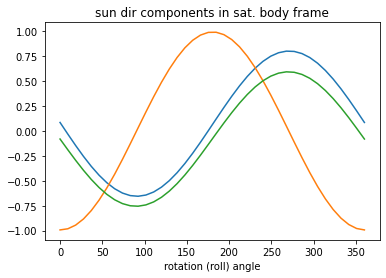

In [175]:
#np.allclose(rmatx.T@rmatx,np.eye(3)) # rmatx is orthonormal
j=0
rmatx=triad(mbody[j],[0,0,1])
#awee=np.array([np.cos(angle2[j])*np.ones_like(phi),np.sin(angle2[j])*np.cos(phi),np.sin(angle2[j])*np.sin(phi)])#
awee=np.array([np.cos(angle2[j])*np.ones_like(phi),np.sin(angle2[j])*np.cos(phi),np.sin(angle2[j])*np.sin(phi)])#
asun=rmatx.T@awee# in body frame
        #triad(mbody[j],[0,1,0]).T@awee[j] for  
[pl.plot(np.rad2deg(phi),s) for s in asun]
pl.title("sun dir components in sat. body frame")
pl.xlabel("rotation (roll) angle")

In [179]:
np.std([a.dot(mbody[j]) for a in asun.T])

4.3610271956070115e-17

#### similar for Earth (as light source) 

In [180]:
#[a for a in nadir.fk5.cartesian]
nadir_eci=su.eloc2cart(nadir.fk5.cartesian)
i=0
np.rad2deg(np.arccos(np.dot(mag_inter(dt[i]),nadir_eci))),np.rad2deg(np.arccos(np.dot(sunvec_eci[i],nadir_eci)))

(137.83193465747752, 90.24898556489393)

### try some model

we don't have much details about the sensor from [NEEDRONIX](https://sunsensor.eu/NXSS3v00.html)

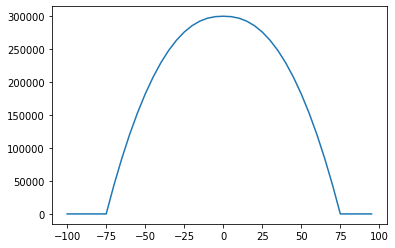

In [181]:
sens_amp=3e5
mang=75
zex=2.3
viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*sens_amp
angs=np.r_[-100:100:5]
pl.plot(angs,[viewang(a) for a in angs])

#### simulate SunSensor signal for different roll angle

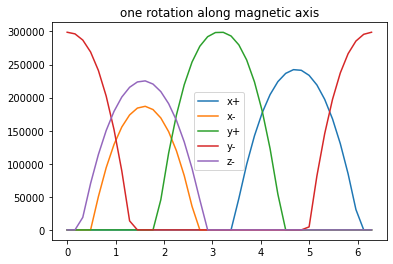

In [182]:
def predict_roll(asun):
    xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
    yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
    zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
    return xp,yp,xm,ym,zm
xp,yp,xm,ym,zm=predict_roll(asun)
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

In [183]:
tle_all=open("/home/limu/Code/Notebook/Astro/alpha/ephem/tle_all.txt").readlines()
tle_arr=[tle_all[4*i+1].replace('-','.').replace('+','.').split()[3:]+tle_all[4*i+2].replace('-','.').split()[2:] for i in range(len(tle_all)//4)]

In [184]:
from datetime import timezone#.utc as utc
timezone.utc
#now.tzinfo
#timezone.timezone('Europe/Prague')
t=trans[2]
datetime.fromtimestamp(t.start,timezone.utc)#.tzinfo

datetime.datetime(2022, 5, 11, 7, 18, 28, 946164, tzinfo=datetime.timezone.utc)

In [185]:
times=[[datetime.fromtimestamp(tx,timezone.utc).isoformat()[:19].replace('T',' ') for tx in [t.start,t.peak()['epoch'],t.end]] for t in trans]

In [186]:
gpos=lambda p:[p["longitude"],p["latitude"]]
zpos=[gpos(t.peak()) for t in trans]
zpos[:10]

[[42.11045837718816, 47.384761781460476],
 [18.860034743036834, 49.155764193606075],
 [41.22620930173441, 54.173219982533546],
 [19.660307497406617, 48.495578530990734],
 [43.58998338037407, 47.44080541522315],
 [20.22635170899193, 48.90886647636029],
 [358.9384862039982, 55.09611369871949],
 [42.46002136277636, 54.66164958954458],
 [21.04052683799919, 48.71141034536683],
 [21.60283525338595, 48.68169702152442]]

### statistics of other HK data

In [34]:
import pickle
irnorm=pickle.load(open("coramp.pkz","rb"))

In [35]:
irnorm

array([[13460.6, 23544.6],
       [10851.5, 23139.5],
       [16331.5, 29408.6],
       [11708. , 20586. ],
       [10867.8, 22073.8]])

In [191]:
times=[datetime.strptime(m,"%d-%m-%Y %H:%M:%S") for m in mok['DK TimeStamp']]
dt=[(t-times[0]).seconds for t in times]

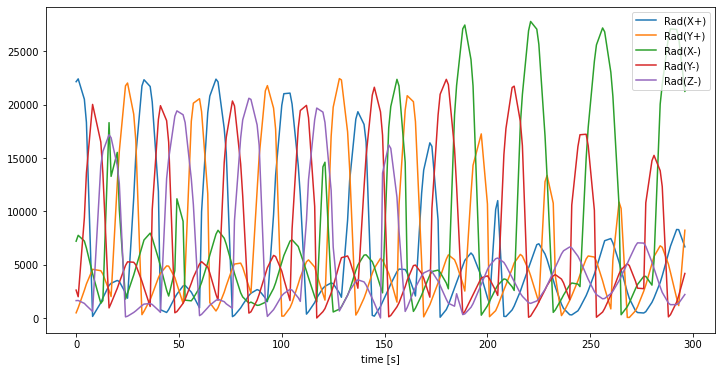

In [37]:
fig=pl.figure(figsize=(12,6))
irsens=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in irpos]])
pl.xlabel("time [s]")
[pl.plot(dt,s) for s in irsens]
pl.legend([mok.columns[i][4:] for i in irpos])
pl.savefig("/home/limu/Space/logs/alpha/sunsens_october.png")

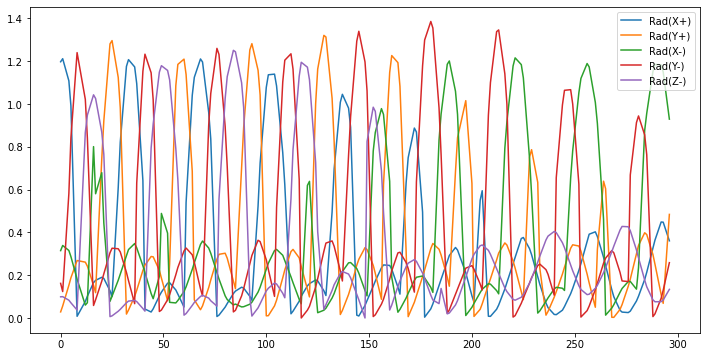

In [38]:
irsens2=irsens*2/(irnorm[:,0]+irnorm[:,1])[:,np.newaxis]
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2]
pl.legend([mok.columns[i][4:] for i in irpos])

[[<matplotlib.lines.Line2D at 0x7fe4a329f190>],

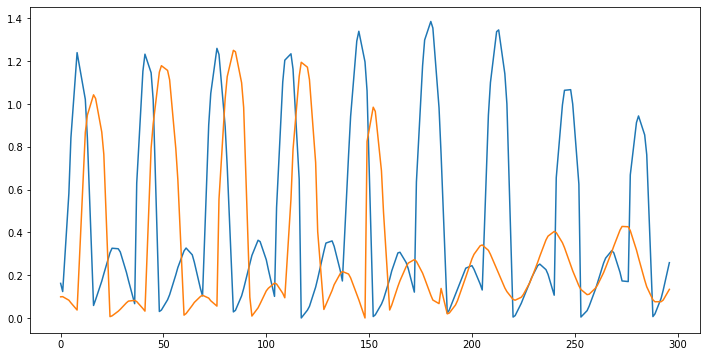

In [39]:
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2[-2:]]

(0.0, 120.0)

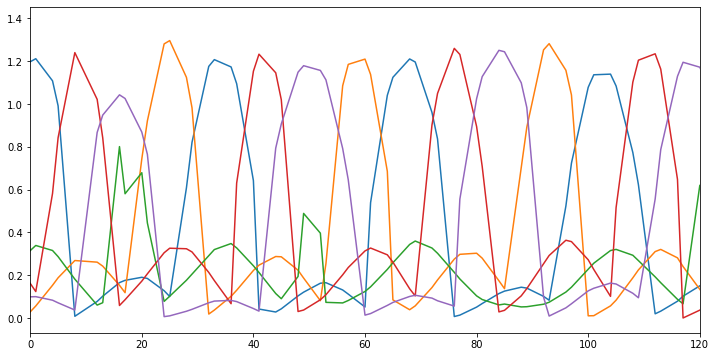

In [40]:
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2]
pl.xlim(0,120)

### rotating model vs. reality

Text(0, 0.5, 'simulated')

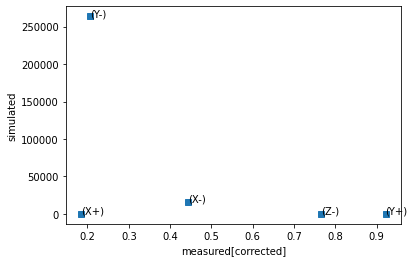

In [41]:
labels=[mok.columns[i][7:] for i in irpos]
simu=np.array([xp,yp,xm,ym,zm])
k=10
pl.plot(irsens2[:,k],simu[:,2],'s')
for i in range(5):
    pl.text(irsens2[i,k],simu[i,2],labels[i])
np.corrcoef(irsens2[:,k],simu[:,2])[0][1]
pl.xlabel("measured[corrected]")
pl.ylabel("simulated")
#pl.plot(phi,xp,phi,xm)
#pl.plot(phi,yp,phi,ym)
#pl.plot(phi,zm)

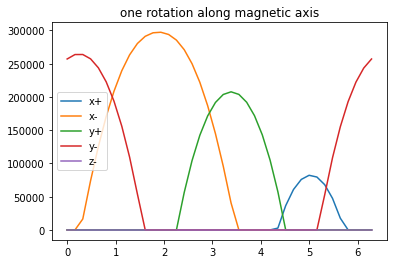

In [42]:
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

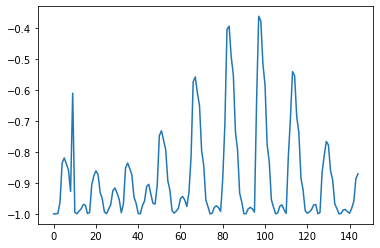

In [43]:
aliad=[triad(m,[0,0,1]) for m in mbody]
pl.plot([a[1][1] for a in aliad])

In [192]:
len(times),len(dt)

(147, 147)

failed 145
failed 146


Text(0, 0.5, 'roll angle[deg]')

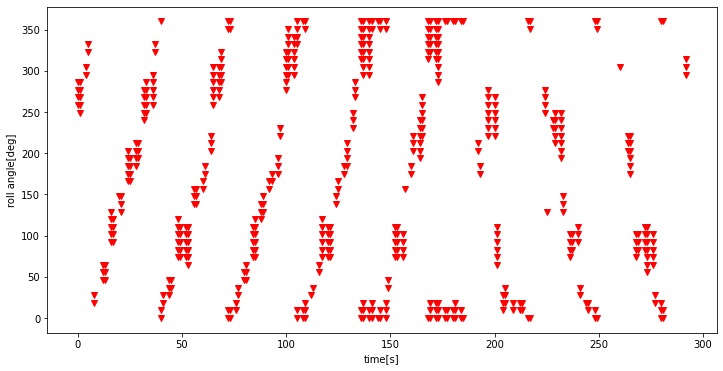

In [196]:
pl.figure(figsize=(12,6))
dphi=np.rad2deg(phi)
rmatx=triad(mbody[3],[0,0,1])
good_angs=[]
match_stats=[]
for i in range(len(times)):
    awee=np.array([np.cos(angle2[i])*np.ones_like(phi),np.sin(angle2[i])*np.cos(phi),np.sin(angle2[i])*np.sin(phi)])# sun dir in EQ frame
    #rmatx=triad(mbody[i],[0,0,1])
    try:
        asun=aliad[i].T@awee # in body frame
        simu=np.array(predict_roll(asun))
    except:
        print(f"failed {i}")
        good_angs.append([])
        continue
    prof1=[np.corrcoef(irsens2[:,i],s)[0][1] if s.std()>100 else 0 for s in simu.T]
    prof1=np.array(prof1)
    match_stats.append(np.percentile(prof1,[0,10,90,100]))
    pind=np.where(prof1>=0.95*prof1.max())[0]
    pl.plot(dt[i]*np.ones_like(pind),dphi[pind],'rv')
    good_angs.append(dphi[pind])
pl.xlabel("time[s]")
pl.ylabel("roll angle[deg]")

In [194]:
prof1.max()*0.95

0.07466232124612046

In [47]:
phi0=good_angs[0].mean()
timsel=np.array([dt[i] for i in range(len(good_angs)) if np.any((np.r_[good_angs[i]]>200)*(np.r_[good_angs[i]]<210))])
ind_pass=np.where(timsel[1:]-timsel[:-1]>20)[0]+1
tpass=timsel[ind_pass]
period=(tpass[1:]-tpass[:-1]).mean()
phi0,period

(272.3076923076923, 52.0)

In [48]:
tpass[1:]-tpass[:-1]

array([ 33,  35,  37, 103])

In [200]:
imax=sum(np.array(dt)<160)
dt=np.array(dt)
def phi_fun(period,phi0,samp,sphase=90,accel=0):
    phi_max=phi0+360*(dt/period+dt**2*accel)
    phi_max-=360*(phi_max/360).astype(int)
    return phi_max+samp*np.sin(np.deg2rad(phi_max-sphase))

correl=lambda real,simu:np.corrcoef(real,simu)[0][1] if simu.std()>10 else 0
def model(period,phi0,samp,sphase,accel,predict=None):
    if predict==None: predict=predict_roll
    phi_pred=phi_fun(period,phi0,samp,sphase,accel)
    coefs=[]
    for i in range(imax):
        rphi=np.deg2rad(phi_pred[i])
        awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
        asun=rmatx.T@awee # in body frame
        simu=np.array(predict_roll(asun))
        coefs.append(1-correl(irsens2[:,i],simu))

    return sum(coefs)
period=32
pini=[period,phi0,40,140,0]
model(*pini)

48.53100095018484

In [201]:
from scipy.optimize import fmin
pfin=fmin(lambda p:model(*p),pini)
period,phi0,samp,sphase,accel=pfin

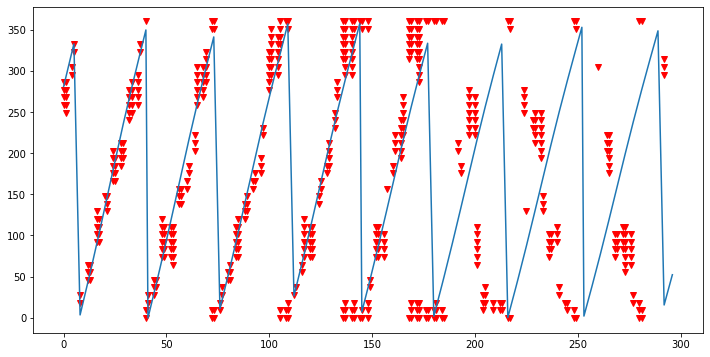

In [202]:
pl.figure(figsize=(12,6))
for i in range(len(dt)):
    pgood=good_angs[i]
    pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
#pl.plot(dt,phi_max,':')
phi_pred=phi_fun(period,phi0,samp,sphase,accel)
pl.plot(dt,phi_pred)

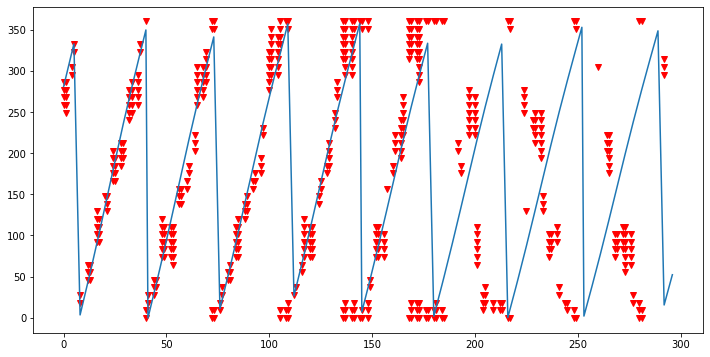

In [203]:
#pfin=[34.17824531, 287.31454935,  29.40824437,  91.28652249,0]
pl.figure(figsize=(12,6))
for i in range(len(dt)):
    pgood=good_angs[i]
    pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
#pl.plot(dt,phi_max,':')
pl.plot(dt,phi_fun(*pfin))

In [199]:
def simu_sun(phi):
    rphi=np.deg2rad(phi)
    awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
    return np.array(predict_roll(rmatx.T@awee))

### how good is overall correlation of model vs. measured sunsensors?

earth albedo contribution is not simulated, so values below 40% of max are neglected in first approx.

In [204]:
wsel=slice(None,100)
bangs=phi_fun(*pfin)[wsel]
simu_all=np.array([simu_sun(p) for p in bangs]).T

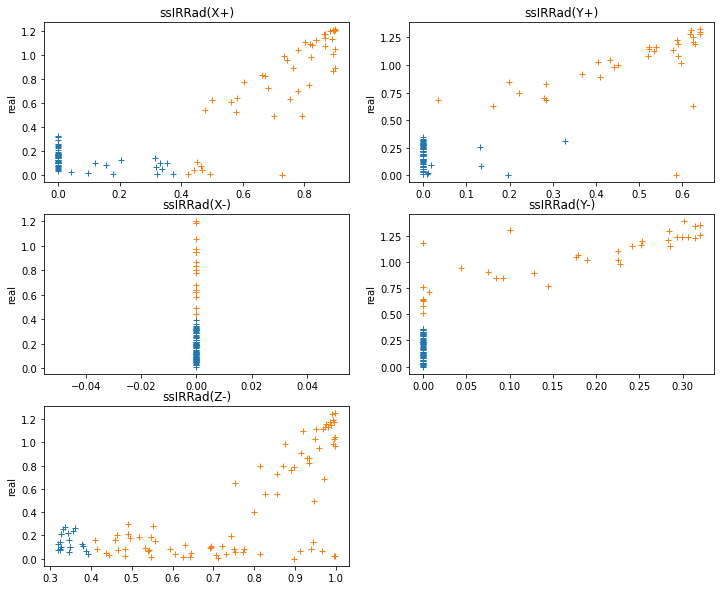

In [206]:
pl.figure(figsize=(12,10))
inlim=0.4
for i in range(5):
    pl.subplot(3,2,i+1)
    bad=((simu_all[i]/sens_amp)<inlim)*(irsens2[i,wsel]<inlim)
    nx,ny=simu_all[i][bad]/sens_amp,irsens2[i,wsel][bad]
    pl.plot(nx,ny,'+')
    nx,ny=simu_all[i][bad==False]/sens_amp,irsens2[i,wsel][bad==False]
    pl.plot(nx,ny,'+')
    pl.title(mok.columns[irpos[i]])
    pl.ylabel('real')

In [56]:
def minfun(pfin,inlim=0.2,maxax=4):
    merit=[]
    bangs=phi_fun(*pfin)[wsel]
    simu_all=np.array([simu_sun(p) for p in bangs]).T
    cldness=[]
    for i in range(maxax):
        bad=((simu_all[i]/sens_amp)<inlim)*(irsens2[i,wsel]<inlim)
        nx,ny=simu_all[i][bad==False]/sens_amp,irsens2[i,wsel][bad==False]
        moo=np.polyfit(nx,ny,1)
        #print(len(nx),sum(bad),moo[0])
        ydist=abs(moo[0]*nx+moo[1]-ny)
        ylim=np.percentile(ydist,90)
        ysel=ydist<ylim
        nx,ny=nx[ysel],ny[ysel]
        goodsum=sum((moo[0]*nx+moo[1]-ny)**2*ny)
        badsum=0 #by default, points in bottom left quadrant have low contribution
        merit.append(goodsum+badsum)
        cldness.append(np.std(nx/ny))
    #print(cldness)
    return sum(merit)
minfun(pfin,0.2,4)

4.919002101891933

In [57]:
pfin_start=pfin.copy()

In [64]:
bslice1=slice(.9,1.1,20j)
bslice2=slice(.8,1.,20j)
#pairs=(np.mgrid[bslice,bslice]*pfin[:2,np.newaxis,np.newaxis]).reshape(2,int(bslice.step.imag)**2).T
pairs=(np.mgrid[bslice,bslice2]).reshape(2,int(bslice.step.imag)**2).T
zall=[]
for p in pairs:
    zall.append(minfun([pfin[0],pfin[1]*p[0],pfin[2]*p[1],pfin[3],pfin[4]]))

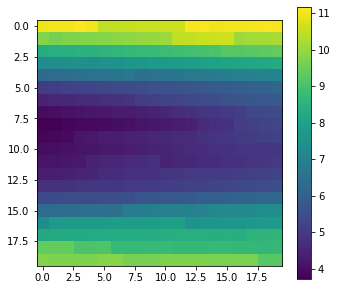

In [65]:
blen=int(bslice.step.imag)
pl.figure(figsize=(5.5,5))
pl.imshow(np.array(zall).reshape(blen,blen))
pl.colorbar()

In [69]:
pmin=np.argmin(zall)
vmin=[bslice.start+(pmin//blen)/blen/5.,bslice2.start+(pmin%blen)/blen/5.]
zall[pmin],pairs[pmin]

(3.7280435649090906, array([0.98421053, 0.8       ]))

In [71]:
pfin_start,pfin1

(array([ 3.34060455e+01,  2.82880195e+02,  2.93081426e+01,  8.55176229e+01,
        -3.89686426e-06]),
 array([ 3.34060455e+01,  2.77222591e+02,  2.34465141e+01,  8.55176229e+01,
        -3.89686426e-06]))

In [70]:
#vmin=pairs[pmin]
pfin1=np.array([pfin[0],pfin[1]*vmin[0],pfin[2]*vmin[1],pfin[3],pfin[4]])
minfun(pfin1)

3.8851623674464326

### modifying parameters of viewangle function

In [277]:
imax=len(dt)
#pfin2=fmin(lambda p:model(*p),pfin)
pfin2

amp=3e5
def model2(period,phi0,samp,sphase,accel,mang=75,zex=2.3):
    viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*sens_amp
    def predict_roll2(asun):
        xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
        yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
        zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
        return xp,yp,xm,ym,zm
    #return model(period,phi0,samp,sphase,accel,predict_roll2)
    phi_pred=phi_fun(period,phi0,samp,sphase,accel)
    coefs=[]
    for i in range(imax):
        rphi=np.deg2rad(phi_pred[i])
        awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
        asun=rmatx.T@awee # in body frame
        simu=np.array(predict_roll2(asun))
        coefs.append(1-correl(irsens2[:,i],simu))

    return sum(coefs)

pini2=list(pfin2)+[75,2.3]
#model2(*pini2)
pfin3=fmin(lambda p:model2(*p),pini2)

Optimization terminated successfully.
         Current function value: 54.800710
         Iterations: 595
         Function evaluations: 906


In [278]:
pfin3

array([3.44654876e+01, 2.87607043e+02, 1.10766707e+01, 1.25009294e+02,
       1.44935576e-06, 7.30307897e+01, 2.24261374e-01])

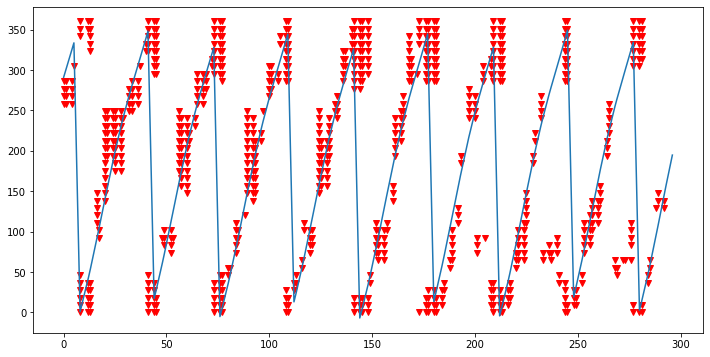

In [280]:
pl.figure(figsize=(12,6))
for i in range(len(dt)):
    pgood=good_angs[i]
    if len(pgood)>0:
        pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
    #pl.axvline(dt[i],0,0.5)
#pl.plot(dt,phi_max,':')
pl.plot(dt,phi_fun(*pfin3[:5]))

current best fit:

- period 34.4654876
- phase 287.607043
- ampl 11.0766707
- phase2 125.009294
- period drift/accel 1.44935576e-06
       
$$ampl (1-\left(\frac{|ang|}{ang_{lim}}\right)^{zex})$$

- limit angle 73.0307897 deg, 
- power 0.224261374 (!)

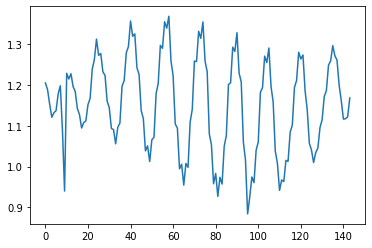

In [90]:
cangs2=(mags[1:,:]*mags[:-1,:]).sum(1)/pomag[0]['total-intensity']**2
pl.plot(cangs2)
#cangs2[cangs2>1]=1
#pl.plot(dt[1:-2][10:40],np.rad2deg(np.arccos(cangs2[10:40])),'-+')

In [218]:
ddt=dt[2:-1]-dt[1:-2]

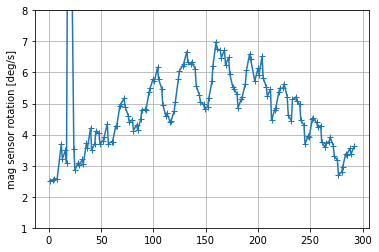

In [231]:
cangs=(mbody[1:,:]*mbody[:-1,:]).sum(1)
pl.plot(dt[1:-2],np.rad2deg(np.arccos(cangs))/ddt,'-+')
pl.ylim(1,8)
pl.grid()
pl.ylabel("mag sensor rotation [deg/s]")
mbad=np.where(np.rad2deg(np.arccos(cangs))/ddt>10)[0]+1

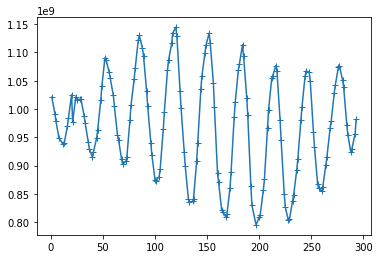

In [64]:
pl.plot(dt[1:-1],(mags**2).sum(1),'-+')

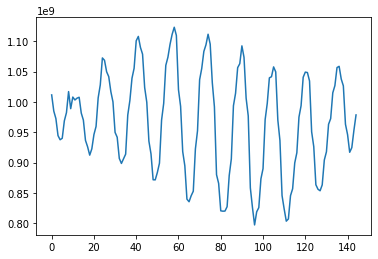

In [229]:
mcop=np.r_[0.99,1.02,1]
pl.plot(((mags*mcop)**2).sum(1))

Text(0, 0.5, '[nT]')

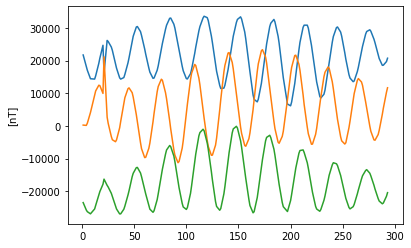

In [236]:
[pl.plot(dt[1:-1],mags[:,i]) for i in range(3)]
pl.ylabel("[nT]")

In [232]:
len(dt)

147

[[<matplotlib.lines.Line2D at 0x7fe4755f19c0>],

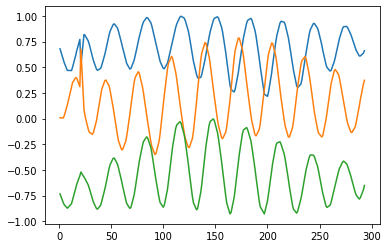

In [237]:
[pl.plot(dt[1:-1],mbody[:,i]) for i in range(3)]

In [234]:
ddt

array([3, 1, 3, 4, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 4, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1])